100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Client 0 Round 1 - Accuracy: 0.0273, Loss: 10.7983, Reputation: 0.75
Client 7 Round 1 - Accuracy: 0.0253, Loss: 10.8587, Reputation: 0.75
Client 3 Round 1 - Accuracy: 0.0232, Loss: 8.9395, Reputation: 0.75
Client 5 Round 1 - Accuracy: 0.0362, Loss: 9.5934, Reputation: 0.75
Client 9 Round 1 - Accuracy: 0.0351, Loss: 10.6697, Reputation: 0.75
Client 4 Round 1 - Accuracy: 0.0295, Loss: 10.2583, Reputation: 0.75
Client 1 Round 1 - Accuracy: 0.0173, Loss: 9.9844, Reputation: 0.75
Client 8 Round 1 - Accuracy: 0.0248, Loss: 10.1772, Reputation: 0.75
Client 6 Round 1 - Accuracy: 0.0310, Loss: 10.1788, Reputation: 0.75
Client 2 Round 1 - Accuracy: 0.0195, Loss: 10.2300, Reputation: 0.75
Client 9 Round 2 - Accuracy: 0.0289, Loss: 10.9116, Reputation: 0.80
Client 0 Round 2 - Accuracy: 0.0161, Loss: 10.4059, Reputation: 0.80
Client 7 Round 2 - Accuracy: 0.0236, Loss: 10.0769, Reputation: 0.80
Client 5 Round 2 - Accuracy: 0.0283, Loss: 11.0025, Reputation: 0.80
Client 6 Round 2 - Accuracy: 0.0451, 

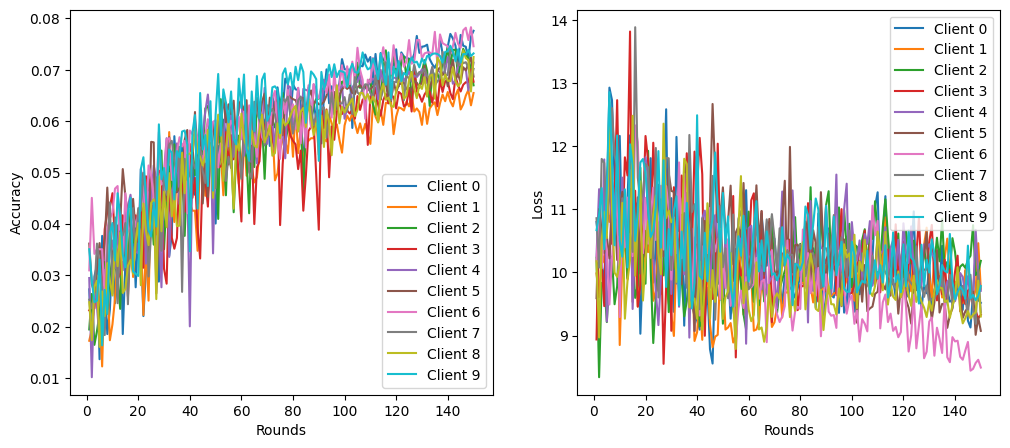

In [1]:
import torch
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import threading
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
random.seed(42)
numpy_rng = np.random.default_rng(42)

# Function to create non-IID data partitioning: Each client gets 10 unique classes
def split_dataset_label_skew(dataset, num_clients=10, num_classes=100):
    classes_per_client = num_classes // num_clients
    indices_by_class = {i: [] for i in range(num_classes)}

    for idx, (_, label) in enumerate(dataset):
        indices_by_class[label].append(idx)

    for label in indices_by_class:
        numpy_rng.shuffle(indices_by_class[label])

    clients_indices = []
    for i in range(num_clients):
        selected_classes = list(range(i * classes_per_client, (i + 1) * classes_per_client))
        indices = [idx for cls in selected_classes for idx in indices_by_class[cls]]
        clients_indices.append(indices)

    return [Subset(dataset, indices) for indices in clients_indices]

# Updated model with correct pooling
class SCAFFOLDNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(128 * 8 * 8, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        return self.fc(x)

class Client:
    def __init__(self, client_id, dataset, shared_memory, timestamps, neighbor_dict, c_local, c_global, mu=0.01):
        self.client_id = client_id
        self.dataset = dataset
        self.shared_memory = shared_memory
        self.timestamps = timestamps
        self.neighbor_dict = neighbor_dict
        self.c_local = c_local
        self.c_global = c_global
        self.history = []
        self.memory_lock = threading.Lock()
        self.reputation = 0.7
        self.mu = mu

    def update_reputation(self, prev_loss, new_loss):
        if new_loss < prev_loss:
            self.reputation = min(1.0, self.reputation + 0.05)
        else:
            self.reputation = max(0.0, self.reputation - 0.1)

    def train(self, parameters, lr):
        net = SCAFFOLDNet().to(device)
        net.load_state_dict(parameters)
        optimizer = optim.SGD(net.parameters(), lr=lr)
        dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True)

        prev_loss = float('inf')
        for _ in range(3):  # Train for 3 epochs per round
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = net(images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()

        accuracy, new_loss = self.get_metrics(net)
        self.update_reputation(prev_loss, new_loss)

        return net.state_dict(), accuracy, new_loss

    def get_metrics(self, net):
        dataloader = DataLoader(dev_dataset, batch_size=64)
        correct, total = 0, 0
        total_loss = 0.0
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = F.cross_entropy(outputs, labels, reduction='sum')
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        avg_loss = total_loss / total
        return accuracy, avg_loss

# Data loading
num_clients = 10
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = split_dataset_label_skew(train_dataset, num_clients), test_dataset

# Shared memory and structures
shared_memory = {}
timestamps = {i: 0 for i in range(num_clients)}
neighbor_dict = {i: [] for i in range(num_clients)}
c_global = {name: torch.zeros_like(param) for name, param in SCAFFOLDNet().state_dict().items()}

clients = [Client(i, train_dataset[i], shared_memory, timestamps, neighbor_dict, c_global.copy(), c_global) for i in range(num_clients)]

# Asynchronous training
def train_asynchronously(client_id, client, max_rounds, base_lr):
    lr = base_lr
    for round_num in range(max_rounds):
        if client.reputation < 0.3:
            print(f"Client {client_id} removed due to low reputation ({client.reputation:.2f})")
            return

        neighbors = random.sample(range(num_clients), random.randint(1, num_clients - 1))
        client.neighbor_dict[client_id] = neighbors
        available_params = [client.shared_memory[neighbor] for neighbor in neighbors if neighbor in client.shared_memory]
        aggregated_params = SCAFFOLDNet().state_dict() if not available_params else available_params[0]

        updated_params, accuracy, loss = client.train(aggregated_params, lr)

        client.shared_memory[client_id] = updated_params
        client.history.append((accuracy, loss))  # ✅ Ensure history updates once per round

        print(f"Client {client_id} Round {round_num + 1} - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}, Reputation: {client.reputation:.2f}")

        if (round_num + 1) % 5 == 0:
            lr *= 0.9

# Plotting function
def plot_combined_metrics(clients):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for client in clients:
        plt.plot(range(1, len(client.history) + 1), [entry[0] for entry in client.history], label=f'Client {client.client_id}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for client in clients:
        plt.plot(range(1, len(client.history) + 1), [entry[1] for entry in client.history], label=f'Client {client.client_id}')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Start training
threads = [threading.Thread(target=train_asynchronously, args=(i, client, 150, 0.02)) for i, client in enumerate(clients)]

for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

# Plot results
plot_combined_metrics(clients)
